# VISUALISE RESULTS

### Import relevant packages

In [1]:
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import numpy as np

from sklearn.metrics import precision_recall_fscore_support, f1_score

sns.set(font_scale=1.3)
sns.set_style()

### Load results across test sets
Each "result" is a csv of gold labels and model predictions.
The results are stored in a nested dict: testset -> model -> train_size -> random_state (including "al" for active learning)

In [2]:
results_dict = dict()

MODELS = ["xlmt","robertuito", "camembert", "arabert", "umberto", "bertimbau"]
SIZES = [10,20,30,40,50,100,200,300,400,500,1000,2000]
RANDOM_STATES = ["rs"+str(i) for i in range(1,11)]+["al"]

for testset in os.listdir("./results"):
    print(testset)
    results_dict[testset] = dict()
    for model in pd.unique([m.split("_")[0] for m in os.listdir(f"./results/{testset}")]):
        results_dict[testset][model] = dict()
        for size in SIZES:
            results_dict[testset][model][size] = dict()
            for random_state in RANDOM_STATES:
                for filename in glob.glob(f"./results/{testset}/{model}_*_{size}_{random_state}.csv"):
                    results_dict[testset][model][size][random_state] = pd.read_csv(filename)

bas19_es_test_2000
ous19_fr_test_1500
ous19_ar_test_1000
san20_it_test_2000
for19_pt_test_2000


### Compute macro F1 for each model/testset combination

In [3]:
metrics_dict = copy.deepcopy(results_dict)

for testset in metrics_dict:
    print(testset)
    for model in metrics_dict[testset]:
        print(" ", model)
        for size in metrics_dict[testset][model]:
            for random_state in metrics_dict[testset][model][size]:
                metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                            metrics_dict[testset][model][size][random_state]["prediction"],
                                                                            average="macro")

bas19_es_test_2000
  xlmt
  robertuito
ous19_fr_test_1500
  camembert
  xlmt
ous19_ar_test_1000
  arabert
  xlmt
san20_it_test_2000
  xlmt
  umberto
for19_pt_test_2000
  bertimbau
  xlmt


### Create flat df of results for easier plotting

In [16]:
results_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                results_df.loc[len(results_df)+1] = [testset, model, size, selection_strat, metrics_dict[testset][model][size][selection_strat]]
                
results_df["sample"] = results_df.selection_strat.apply(lambda x: "active learning" if x=="al" else "random")

### Average macro F1 across random seeds for same model/testset

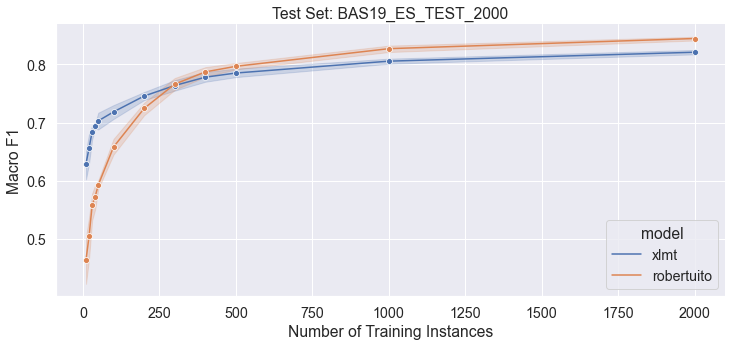

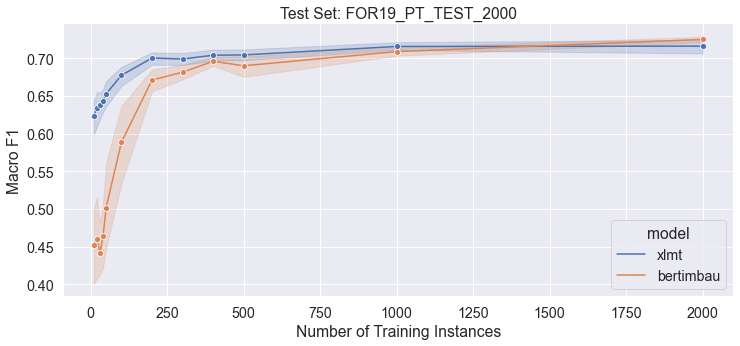

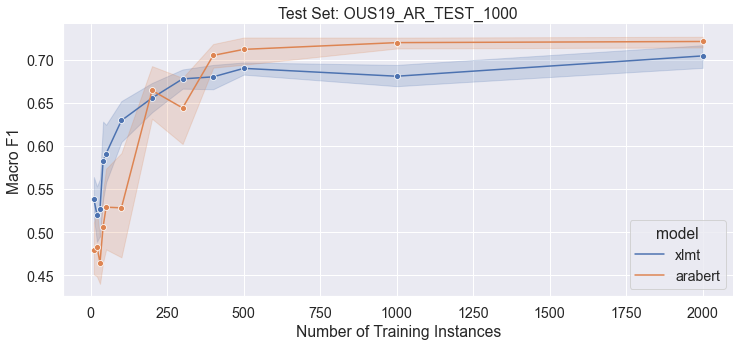

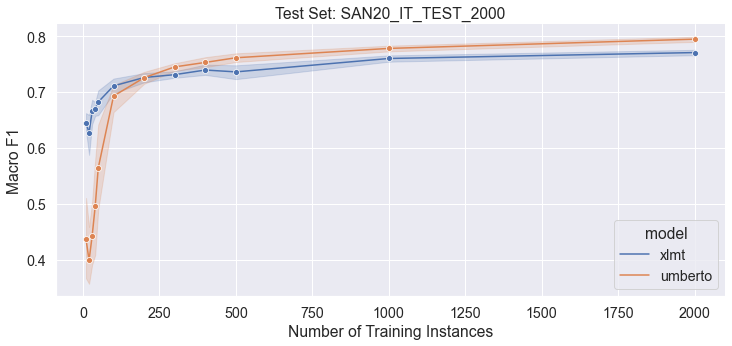

In [21]:
for target_testset in sorted([t for t in metrics_dict.keys() if "fr" not in t]):

    f = plt.figure(figsize=(12,5))
    
    
    # Just random samples
    plot_df = results_df[(results_df.testset==target_testset) & (results_df.selection_strat!="al")].sort_values(["model"], ascending=False)
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # With AL samples
    #plot_df = results_df[(results_df.testset==target_testset) & (results_df.model!="xlmt")].sort_values(["model","sample"], ascending=False)
    #p = sns.lineplot(x="train_size", y="macro_f1", hue="model", style="sample", data = plot_df, estimator="mean", marker="o", ci=95)
    
    p.set_title(f"Test Set: {target_testset.upper()}")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    sns.despine()
    plt.show()

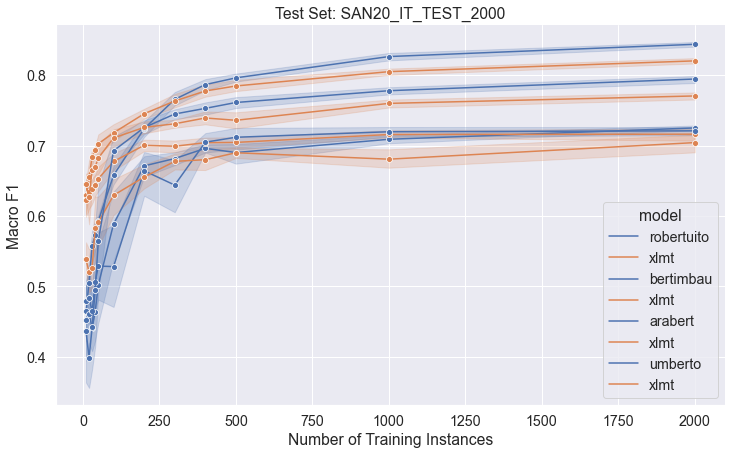

In [18]:
f = plt.figure(figsize=(12,7))

for target_testset in sorted([t for t in metrics_dict.keys() if "fr" not in t]):

    # exclude models trained on active learning "al" data
    plot_df = results_df[(results_df.testset == target_testset) & (results_df.selection_strat!="al")].sort_values("model")


    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df,
                     estimator="mean", marker="o", ci=95)
    p.set_title(f"Test Set: {target_testset.upper()}")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    sns.despine()
    #plt.show()